# Yolo v1

In [1]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.patches as patches
import pandas as pd
import matplotlib.pyplot as plt
import random
import glob
import cv2
import os
from collections import Counter


In [184]:
seed = 123
torch.manual_seed(seed)


LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16
WEIGHT_DECAY = 0
EPOCHS = 100
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "/kaggle/input/pascalvoc-yolo/images"
LABEL_DIR = "/kaggle/input/pascalvoc-yolo/labels"

## dataset

In [3]:
os.listdir("/kaggle/input/pascalvoc-yolo")

['labels',
 'generate_csv.py',
 '8examples.csv',
 'get_data',
 '100examples.csv',
 'images',
 'train.csv',
 'test.csv']

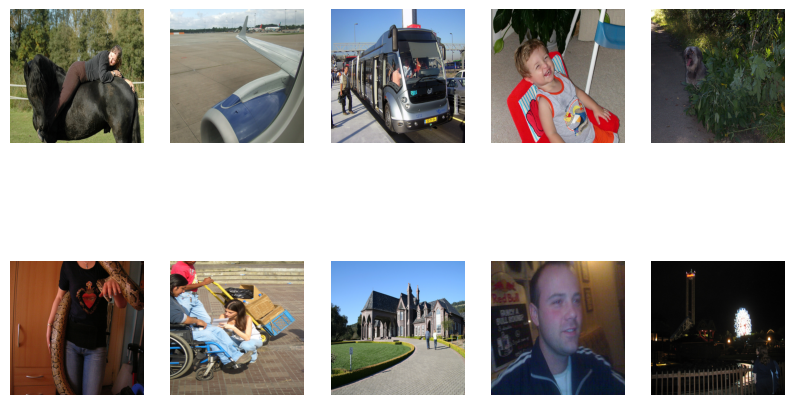

In [4]:
plt.figure(figsize=(10,6))
images=random.sample(glob.glob("/kaggle/input/pascalvoc-yolo/images/*"),10)

for idx,image in enumerate(images):
  img=cv2.imread(image)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,(448,448))
  img=img.astype(float)
  img=img/255
  plt.subplot(2,5,idx+1)
  plt.imshow(img)
  plt.axis("off")

plt.show()


### compose

In [101]:
class Compose(object):
  def __init__(self ,transforme):
    self.transforme =transforme
  def __call__(self, img,boxes) :
    for trans in self.transforme:
      img,boxes=trans(img),boxes
    return img,boxes
transformations =Compose([transforms.Resize((448,448)),transforms.ToTensor()])
# ,transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])





In [6]:
class PacsalDataset(torch.utils.data.Dataset):
  def __init__(self,csv_file,image_dir,label_dir,S=7,C=20,B=2,transform=None):
    self.annotation=pd.read_csv(csv_file)
    self.c=C
    self.s=S
    self.b=B
    self.image_dir=image_dir
    self.label_dir=label_dir
    self.transforme=transform
  def __len__(self):
    return len(self.annotation)
  def __getitem__(self,index):
    label=self.annotation.iloc[index,1]
    path=os.path.join(self.label_dir,label)
    # print(path)
    boxes=[]
    with open(path) as f :
      for box in f.readlines() :
        # print(box)
        boxes.append([float(x) if float(x)!=int(float(x)) else int(x) for x in box.replace("/n","").split()])
      boxes=torch.tensor(boxes)
    image_path=os.path.join(self.image_dir,self.annotation.iloc[index,0])
    image=Image.open(image_path)
    boxes=torch.tensor(boxes)
    if self.transforme :
      image,boxes=self.transforme(image,boxes)
    transformed_label=torch.zeros(self.s,self.s,self.c+5*self.b)
    for box in boxes:
      num_classes,x,y,width,height=list(box)
      i,j=int(self.s*y),int(self.s*x)
      x_cell,y_cell=(self.s*x-j),(self.s*y-i)
      width_cell=self.s*width
      height_cell=self.s*height
      if transformed_label[i,j,20]==0:
        transformed_label[i,j,20]=1
        coordinate=torch.tensor([x_cell,y_cell,width_cell,height_cell])
        # print(coordinate)
        # print(transformed_label[i,j,21,25].shape)
        transformed_label[i,j,21:25]=coordinate
        transformed_label[i,j,int(num_classes)]=1
    return image,transformed_label








In [7]:
test=PacsalDataset("/kaggle/input/pascalvoc-yolo/8examples.csv","/kaggle/input/pascalvoc-yolo/images","/kaggle/input/pascalvoc-yolo/labels",transform=transformations)

In [8]:
image,label=test[1]

/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


In [9]:
label.shape

torch.Size([7, 7, 30])

## Utils

### Intersection over union

In [10]:
def intersection_over_union(correct_boxes,predect_boxes,box_format="midpoint"):
  correct_boxes=torch.tensor(correct_boxes)
  predect_boxes=torch.tensor(predect_boxes)
  if box_format == "midpoint":
    box1_x1 = correct_boxes[..., 0:1] - correct_boxes[..., 2:3] / 2
    box1_y1 = correct_boxes[..., 1:2] - correct_boxes[..., 3:4] / 2
    box1_x2 = correct_boxes[..., 0:1] + correct_boxes[..., 2:3] / 2
    box1_y2 = correct_boxes[..., 1:2] + correct_boxes[..., 3:4] / 2
    box2_x1 = predect_boxes[..., 0:1] - predect_boxes[..., 2:3] / 2
    box2_y1 = predect_boxes[..., 1:2] - predect_boxes[..., 3:4] / 2
    box2_x2 = predect_boxes[..., 0:1] + predect_boxes[..., 2:3] / 2
    box2_y2 = predect_boxes[..., 1:2] + predect_boxes[..., 3:4] / 2
  if box_format == "corners":
    box1_x1=correct_boxes[...,0:1]
    box1_y1=correct_boxes[...,1:2]
    box1_x2=correct_boxes[...,2:3]
    box1_y2=correct_boxes[...,3:4]
    box2_x1=predect_boxes[...,0:1]
    box2_y1=predect_boxes[...,1:2]
    box2_x2=predect_boxes[...,2:3]
    box2_y2=predect_boxes[...,3:4]
  inter_x1=torch.max(box1_x1,box2_x1)
  inter_y1=torch.max(box1_y1,box2_y1)
  inter_x2=torch.min(box1_x2,box2_x2)
  inter_y2=torch.min(box1_y2,box2_y2)
  intersection=(inter_x2-inter_x1).clamp(0)*(inter_y2-inter_y1).clamp(0)
  correct_box_area=(box1_x2-box1_x1)*(box1_y2-box1_y1)
  predectt_box_area=(box2_x2-box2_x1)*(box2_y2-box2_y1)
  return intersection/(correct_box_area+predectt_box_area-intersection+1e-6)




### Non max suppresion

In [11]:
def NMS(boxes,iou_threshold,threshold,box_format="corners") :
  boxes=[box for box in boxes if box[1]>threshold]
  boxes=sorted(boxes,key=lambda x :x[1],reverse=True)
  boxes_after_nms=[]
  while boxes:
    chosen_box=boxes.pop(0)
    boxes=[box for box in boxes if box[0]!= chosen_box[0] or intersection_over_union(chosen_box[2:],box[2:],box_format)< iou_threshold ]
    boxes_after_nms.append(chosen_box)
  return boxes_after_nms


### mean average precision

In [28]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):



    average_precisions = []


    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])


        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)


        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):

            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:

                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))

        average_precisions.append(torch.trapz(precisions, recalls))
    print(average_precisions)
    return sum(average_precisions) / len(average_precisions)

### coordinate converter

In [13]:
def convert_cell_entier_image(predictions,s=7):
  predictions=predictions.to("cpu")
  batch_size=predictions.shape[0]
  predictions=predictions.reshape(batch_size,s,s,30)
  box1=predictions[...,21:25]
  box2=predictions[...,26:30]
  # print(box1)
  best_box =torch.cat([predictions[...,20].unsqueeze(0),predictions[...,25].unsqueeze(0)],dim=0).argmax(0).unsqueeze(-1)
  predictions_box=(best_box*box2+(1-best_box)*box1)
  # print(predictions_box)
  cell=torch.arange(7).repeat(batch_size,s,1).unsqueeze(-1)
  x_cell=(1/s)*(predictions_box[...,:1]+cell)
  y_cell=(1/s)*(predictions_box[...,1:2]+cell.permute(0,2,1,3))
  # print(predictions_box[...,2:4])
  w_h=torch.divide(predictions_box[...,2:4],s)
  # print(w_h)
  coodirate=torch.cat([x_cell,y_cell,w_h],dim=-1)
  predicted_class=predictions[...,:20].argmax(-1).unsqueeze(-1)
  best_score=torch.max(predictions[...,20],predictions[...,25]).unsqueeze(-1)
  # print(best_score)
  # print(best_score)
  convertd_pred=torch.cat([predicted_class,best_score,coodirate],dim=-1)
  # print(convertd_pred)
  # print(convertd_pred.shape)
  return convertd_pred




### cell to boxes

In [44]:
def cell_to_boxes(out,s=7):
  converted_pred=convert_cell_entier_image(out).reshape(out.shape[0],s*s,-1)
  converted_pred[...,0]=converted_pred[...,0].long()
  all_boxes=[]
  for b_idx in range(out.shape[0]):
    boxes=[]
    for grid_idx in range(s*s):
      boxes.append([x.item()for x in converted_pred[b_idx,grid_idx,:]])
    all_boxes.append(boxes)
  return all_boxes


### Get all the boxes

In [58]:
def get_boxes(loader,model,iou_threshold,pred_threshold,box_format="midpoint",device="cuda"):
  model.eval()
  train_idx=0
  all_pred=[]
  all_true=[]
  for batch_idx ,(x,labels) in enumerate(loader):
    x=x.to(device)
    labels=labels.to(device)
    
    with torch.no_grad():
      predection=model(x)
    predection=predection
#     print(predction)
    batch_size=x.shape[0]
    converted_labels=cell_to_boxes(labels)
    converted_pred=cell_to_boxes(predection)
#     print(converted_pred)
#     print("hellp")
    for idx in range(batch_size):
      boxes_a_nms=NMS(converted_pred[idx],iou_threshold,pred_threshold,box_format)
      for nms_box in boxes_a_nms:
        # print(nms_box[1])
        all_pred.append([train_idx]+nms_box)
      # print(converted_labels[idx])
      for label in converted_labels[idx]:
            
#         print(label[1])
        if label[1] > pred_threshold:
          all_true.append([train_idx]+label)
      train_idx+=1
  model.train()
  return all_pred,all_true





### plot images

In [160]:
def plot_images(image,boxes,axis,idx):
  image=image.to("cpu")
#   print(image.shape)
  _,width,height=image.shape
  image=np.array(image.permute(1,2,0))
  axis[idx].imshow(image)
#   print(image.shape)
 
  for box in boxes  :
    box = box[2:]
    top_x = box[0]-box[2]/2
    top_y=box[1]-box[3]/2
    rec=patches.Rectangle((top_x*width,top_y*height),box[2]*width,box[3]*height,linewidth=1,
            edgecolor="r",
            facecolor="none",)
    axis[idx].add_patch(rec)
  axis[idx].axis("off")
  return axis[idx]

### chekpoint

In [17]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

## model architecteur


In [18]:
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [19]:
class CnnModel(nn.Module):
  def __init__(self,in_channels,out_channels,**kwargs):
    super().__init__()
    self.conv=nn.Conv2d(in_channels,out_channels,bias=False,**kwargs)
    self.bachnorm=nn.BatchNorm2d(out_channels)
    self.leakyRelu=nn.LeakyReLU(0.1)
  def forward(self,x):
    return self.leakyRelu(self.bachnorm(self.conv(x)))
class Yolov1(nn.Module):
  def __init__(self,in_channels=3,**kwargs):
    super().__init__()
    self.in_channels=in_channels
    self.architecture=architecture_config
    self.darknet=self.conv_layers_create(self.architecture)
    self.fcs=self.create_fcs(**kwargs)
  def forward(self,x):
    x=self.darknet(x)
    return self.fcs(torch.flatten(x,start_dim=1))
  def conv_layers_create(self,architecture):
    layers=[]
    in_channels=self.in_channels
    for layer in architecture:
      if type(layer) == tuple:
        layers+=[CnnModel(in_channels,layer[1],kernel_size=layer[0],stride=layer[2],padding=layer[3])]
        in_channels=layer[1]
      elif type(layer)==str :
        layers+=[nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))]
      elif type(layer)== list :
        conv1=layer[0]
        conv2=layer[1]
        num_of_rep=layer[2]
        for _ in range (num_of_rep):
          layers+=[CnnModel(in_channels,conv1[1],kernel_size=conv1[0],stride=conv1[2],padding=conv1[3])]
          layers+=[CnnModel(conv1[1],conv2[1],kernel_size=conv2[0],stride=conv2[2],padding=conv2[3])]
          in_channels=conv2[1]
    return nn.Sequential(*layers)
  def create_fcs(self,num_split,num_bord,num_class):
    S=num_split
    B=num_bord
    C=num_class
    return nn.Sequential(nn.Flatten(),nn.Linear(1024*S*S,496),nn.Dropout(0.0),nn.LeakyReLU(0.1),nn.Linear(496,S*S*(C+B*5)))



In [20]:
!pip install torchsummary

In [21]:
from torchsummary import summary
def test(S=7,B=2,C=20):
  model=Yolov1(num_split=S,num_bord=2,num_class=20).to("cuda")
  image=torch.rand((2,3,448,448)).to("cuda")
  print(summary(model,(3,448,448)))

  return model(image).shape


In [22]:
test()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         LeakyReLU-3         [-1, 64, 224, 224]               0
          CnnModel-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 192, 112, 112]         110,592
       BatchNorm2d-7        [-1, 192, 112, 112]             384
         LeakyReLU-8        [-1, 192, 112, 112]               0
          CnnModel-9        [-1, 192, 112, 112]               0
        MaxPool2d-10          [-1, 192, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]          24,576
      BatchNorm2d-12          [-1, 128, 56, 56]             256
        LeakyReLU-13          [-1, 128, 56, 56]               0
         CnnModel-14          [-1, 128,

torch.Size([2, 1470])

## Loss function

In [140]:
class Loss(nn.Module):
  def __init__(self,S=7,B=2,C=20):
    super().__init__()
    self.mse=nn.MSELoss(reduction="sum")
    self.s=S
    self.c=C
    self.b=B
    self.lambda_noobj = 0.5
    self.lambda_coord = 5
  def forward(self,predictions,target):
    predictions=predictions.reshape(-1,self.s,self.s,self.b*5+self.c)
    iou1=intersection_over_union(predictions[...,21:25],target[...,21:25])
    iou2=intersection_over_union(predictions[...,26:30],target[...,21:25])
    ious=torch.cat([iou1.unsqueeze(0),iou2.unsqueeze(0)],dim=0)
    max_iou,best_box=torch.max(ious,dim=0)
    object_exist=target[...,20].unsqueeze(3)
    #the coordiante loss
    selected_anchor=object_exist*((best_box*predictions[...,26:30]+(1-best_box)*predictions[...,21:25]))
    target_box=object_exist*target[...,21:25]
    selected_anchor[...,2:4]=torch.sign(selected_anchor[...,2:4])*torch.sqrt(torch.abs(selected_anchor[...,2:4]+1e-6))
    target_box[...,2:4]=torch.sqrt( target_box[...,2:4])
    coordinate_loss=self.mse(torch.flatten(selected_anchor,end_dim=-2),torch.flatten(target_box,end_dim=-2))
    # the object probabilty loss [if there is an object ]
    predictions_exestence_prob=object_exist*(best_box*predictions[...,25:26]+((1-best_box)*predictions[...,20:21]))
    object_exist_loss=self.mse(torch.flatten(object_exist*predictions_exestence_prob),torch.flatten(object_exist*target[...,20:21]))
    #if there is no object
    no_object_loss=self.mse(torch.flatten((1-object_exist)*predictions[...,20:21],start_dim=1),torch.flatten((1-object_exist)*target[...,20:21],start_dim=1))
    no_object_loss+=self.mse(torch.flatten((1-object_exist)*predictions[...,25:26],start_dim=1),torch.flatten((1-object_exist)*target[...,20:21],start_dim=1))
    
    #the classes loss
    class_loss=self.mse(torch.flatten(object_exist*predictions[...,:20],end_dim=-2),torch.flatten(object_exist*target[...,:20],end_dim=-2))
    loss=(self.lambda_coord*coordinate_loss+object_exist_loss+self.lambda_noobj*no_object_loss+class_loss)
    return loss






## Training

In [24]:
def train_fn(loader,model,optimizer,loss_fn):
  loop=tqdm(loader,leave=True)
  avg_loss=[]
  for batch_idx,(x,label) in enumerate(loop):
    x,label=x.to(DEVICE),label.to(DEVICE)
    predictions=model(x)
    loss=loss_fn(predictions,label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss.append(loss.item())
    loop.set_postfix(loss=loss.item())
  avg_loss=sum(avg_loss)/len(avg_loss)
  print(f"mean loss was {avg_loss}")
  return avg_loss






In [183]:
def main():
   model=Yolov1(num_split=7,num_bord=2,num_class=20).to(DEVICE)
   optimizer=optim.Adam(model.parameters(),lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
   loss_fn=Loss()
   if LOAD_MODEL:
      load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)
   trainDataset=PacsalDataset("/kaggle/input/pascalvoc-yolo/100examples.csv","/kaggle/input/pascalvoc-yolo/images","/kaggle/input/pascalvoc-yolo/labels",transform=transformations)
   testDataset=PacsalDataset("/kaggle/input/pascalvoc-yolo/test.csv","/kaggle/input/pascalvoc-yolo/images","/kaggle/input/pascalvoc-yolo/labels",transform=transformations)
   trainLoader=DataLoader(dataset=trainDataset,batch_size=BATCH_SIZE,pin_memory=PIN_MEMORY,num_workers=NUM_WORKERS,shuffle=True,drop_last=True)
   testLoader=DataLoader(dataset=testDataset,batch_size=BATCH_SIZE,pin_memory=PIN_MEMORY,num_workers=NUM_WORKERS,shuffle=True,drop_last=True)
   mean_map=[]
   mean_loss=[]
   for epoch in range(EPOCHS):
    pred_lab,true_lab=get_boxes(trainLoader,model,iou_threshold=0.5,pred_threshold=0.4,device=DEVICE)
#     print(true_lab)
    mean_avg_pre=mean_average_precision(pred_lab,true_lab,iou_threshold=0.5,box_format="midpoint")
    mean_map.append(mean_avg_pre.item())
#     if mean_avg_pre > 0.9:
#            checkpoint = {
#                "state_dict": model.state_dict(),
#                "optimizer": optimizer.state_dict(),
#            }
#            save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
#            import time
#            time.sleep(10)
    train_loss=train_fn(trainLoader,model,optimizer,loss_fn)
    mean_loss.append(train_loss)
   return model,mean_map,mean_loss




In [185]:
if __name__ == "__main__":
    model,map,loss=main()

/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/261830336.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct_boxes=torch.tensor(correct_boxes)
/tmp/ipykernel_34/261830336.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().req

mean loss was 965.5133768717448



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.05it/s, loss=433]

mean loss was 564.8497670491537



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.21it/s, loss=525]

mean loss was 444.3671366373698



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.11it/s, loss=431]

mean loss was 385.0920918782552



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.13it/s, loss=381]

mean loss was 322.59276580810547



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.15it/s, loss=177]

mean loss was 284.7821095784505



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  3.98it/s, loss=195]

mean loss was 247.15318552652994



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.19it/s, loss=226]

mean loss was 212.93043772379556



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.22it/s, loss=223]

mean loss was 190.36917622884116



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.14it/s, loss=136]

mean loss was 181.8864262898763



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.), tensor(0.), tensor(0.0312), tensor(0.), tensor(0.), tensor(0.0917), tensor(0.0500), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.0045), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.20it/s, loss=126]

mean loss was 169.39574432373047



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.), tensor(0.), tensor(0.0529), tensor(0.), tensor(0.), tensor(0.0833), tensor(0.0216), tensor(0.), tensor(0.), tensor(1.0000), tensor(0.), tensor(0.), tensor(0.0156), tensor(0.), tensor(0.0507), tensor(0.0156), tensor(0.), tensor(0.), tensor(0.1167), tensor(0.)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.25it/s, loss=188] 

mean loss was 157.8917554219564



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.0905), tensor(0.1250), tensor(0.2889), tensor(0.0684), tensor(0.), tensor(0.6667), tensor(0.1500), tensor(0.), tensor(0.0268), tensor(1.0000), tensor(0.), tensor(0.4000), tensor(0.7482), tensor(0.0547), tensor(0.0757), tensor(0.0083), tensor(0.), tensor(0.0083), tensor(0.3750), tensor(0.5000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.16it/s, loss=167]

mean loss was 142.3185920715332



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.2567), tensor(0.0833), tensor(0.1347), tensor(0.0312), tensor(0.0102), tensor(0.5000), tensor(0.3076), tensor(0.0102), tensor(0.1408), tensor(1.0000), tensor(0.), tensor(0.3056), tensor(0.6560), tensor(0.1225), tensor(0.1789), tensor(0.1014), tensor(0.), tensor(0.0319), tensor(0.2219), tensor(0.4000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.12it/s, loss=121] 

mean loss was 134.83646647135416



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.3546), tensor(0.0833), tensor(0.1642), tensor(0.0982), tensor(0.0119), tensor(0.5000), tensor(0.2724), tensor(0.3733), tensor(0.1583), tensor(1.0000), tensor(0.), tensor(0.7766), tensor(0.9809), tensor(0.2518), tensor(0.2826), tensor(0.0625), tensor(0.0684), tensor(0.1676), tensor(0.3153), tensor(0.5000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.20it/s, loss=129] 

mean loss was 118.1166165669759



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.2766), tensor(0.7917), tensor(0.4194), tensor(0.1808), tensor(0.1068), tensor(0.5000), tensor(0.4658), tensor(0.9633), tensor(0.1128), tensor(1.0000), tensor(0.), tensor(0.6935), tensor(1.0000), tensor(0.5462), tensor(0.3406), tensor(0.1628), tensor(0.0804), tensor(0.2711), tensor(0.1850), tensor(0.5000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.13it/s, loss=124] 

mean loss was 103.71327082316081



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.3011), tensor(0.7917), tensor(0.4781), tensor(0.2055), tensor(0.0167), tensor(0.3333), tensor(0.5672), tensor(1.0000), tensor(0.5133), tensor(1.0000), tensor(0.), tensor(0.8268), tensor(1.0000), tensor(0.5971), tensor(0.4720), tensor(0.1883), tensor(0.1190), tensor(0.4625), tensor(0.3350), tensor(0.4000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.16it/s, loss=87.1]

mean loss was 96.03995768229167



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.5350), tensor(0.7917), tensor(0.4194), tensor(0.2411), tensor(0.0391), tensor(0.5000), tensor(0.6253), tensor(1.0000), tensor(0.4966), tensor(1.0000), tensor(0.1250), tensor(0.9742), tensor(1.0000), tensor(0.3923), tensor(0.5658), tensor(0.1437), tensor(0.1083), tensor(0.6292), tensor(0.3506), tensor(0.5774)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.14it/s, loss=121] 

mean loss was 96.57357660929362



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.5358), tensor(0.7917), tensor(0.4593), tensor(0.2583), tensor(0.0167), tensor(0.2083), tensor(0.5981), tensor(0.7671), tensor(0.3675), tensor(1.0000), tensor(0.1944), tensor(1.0000), tensor(1.0000), tensor(0.7958), tensor(0.5880), tensor(0.7958), tensor(0.3854), tensor(0.8000), tensor(0.7167), tensor(0.4900)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.15it/s, loss=99.9]

mean loss was 89.27555338541667



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.7042), tensor(0.7917), tensor(0.5177), tensor(0.2833), tensor(0.2384), tensor(0.2083), tensor(0.5201), tensor(0.8314), tensor(0.3812), tensor(1.0000), tensor(0.1944), tensor(1.0000), tensor(1.0000), tensor(0.8648), tensor(0.5408), tensor(0.2917), tensor(0.2411), tensor(0.6667), tensor(0.6056), tensor(0.5100)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.08it/s, loss=57.2]

mean loss was 76.61709276835124



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.9760), tensor(1.0000), tensor(0.5280), tensor(0.3208), tensor(0.1458), tensor(0.2083), tensor(0.5725), tensor(0.9437), tensor(0.4072), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.9633), tensor(0.5791), tensor(0.8708), tensor(0.2833), tensor(0.6819), tensor(0.4832), tensor(0.5774)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.01it/s, loss=81.5]

mean loss was 80.00667572021484



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.2320), tensor(0.1444), tensor(0.0466), tensor(0.3854), tensor(0.4877), tensor(0.8838), tensor(0.4503), tensor(1.0000), tensor(0.5139), tensor(1.0000), tensor(1.0000), tensor(0.8000), tensor(0.6887), tensor(1.0000), tensor(0.2083), tensor(0.5111), tensor(0.5222), tensor(0.5611)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.23it/s, loss=99.5]

mean loss was 76.42551867167155



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.6294), tensor(1.0000), tensor(0.6255), tensor(0.3042), tensor(0.0983), tensor(0.3854), tensor(0.7009), tensor(0.9588), tensor(0.6213), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6286), tensor(1.0000), tensor(0.3542), tensor(0.8333), tensor(0.6056), tensor(0.7653)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.13it/s, loss=78.2]

mean loss was 72.64280192057292



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.7983), tensor(1.0000), tensor(0.5525), tensor(0.1667), tensor(0.0466), tensor(0.3854), tensor(0.5994), tensor(1.0000), tensor(0.4929), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6618), tensor(0.9083), tensor(0.1667), tensor(0.8000), tensor(1.0000), tensor(0.6056)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.16it/s, loss=62.3]

mean loss was 68.89104143778484



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.7162), tensor(0.2036), tensor(0.0619), tensor(0.3854), tensor(0.8405), tensor(1.0000), tensor(0.8300), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7181), tensor(1.0000), tensor(0.3312), tensor(0.7500), tensor(1.0000), tensor(0.6056)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.15it/s, loss=60.4]

mean loss was 65.7647164662679



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8894), tensor(1.0000), tensor(0.9076), tensor(0.4265), tensor(0.0619), tensor(0.3854), tensor(0.6611), tensor(0.9663), tensor(0.4101), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7704), tensor(1.0000), tensor(0.3312), tensor(0.8000), tensor(1.0000), tensor(0.5893)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.22it/s, loss=82.5]

mean loss was 63.24856440226237



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8894), tensor(1.0000), tensor(0.7983), tensor(0.4265), tensor(0.0722), tensor(0.3854), tensor(0.5552), tensor(1.0000), tensor(0.5031), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6941), tensor(1.0000), tensor(0.1250), tensor(0.8333), tensor(1.0000), tensor(0.6000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.03it/s, loss=86.3]

mean loss was 64.9044075012207



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8776), tensor(1.0000), tensor(0.9569), tensor(0.4437), tensor(0.2024), tensor(0.3854), tensor(0.8932), tensor(1.0000), tensor(0.6425), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7027), tensor(1.0000), tensor(0.9437), tensor(0.3861), tensor(1.0000), tensor(0.6292)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.25it/s, loss=84.3]

mean loss was 67.02605311075847



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.6308), tensor(1.0000), tensor(0.7983), tensor(0.3458), tensor(0.2833), tensor(0.6771), tensor(0.6695), tensor(1.0000), tensor(0.5237), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6267), tensor(0.7060), tensor(1.0000), tensor(0.5729), tensor(0.8000), tensor(1.0000), tensor(0.6667)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.24it/s, loss=51.6]

mean loss was 57.05490175882975



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.7983), tensor(0.4437), tensor(0.0238), tensor(0.6667), tensor(0.6392), tensor(1.0000), tensor(0.3813), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7767), tensor(0.7580), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.9437)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.16it/s, loss=75.2]

mean loss was 56.65330696105957



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.7983), tensor(0.4437), tensor(0.7143), tensor(1.0000), tensor(0.6532), tensor(1.0000), tensor(0.7902), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8500), tensor(1.0000), tensor(0.3854), tensor(0.8333), tensor(1.0000), tensor(0.7817)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.21it/s, loss=48.6]

mean loss was 56.345357259114586



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8894), tensor(1.0000), tensor(1.0000), tensor(0.4917), tensor(0.3167), tensor(0.3854), tensor(0.8441), tensor(1.0000), tensor(0.7702), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7256), tensor(1.0000), tensor(0.1250), tensor(0.8333), tensor(1.0000), tensor(0.6292)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.20it/s, loss=53.1]

mean loss was 52.14929962158203



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8809), tensor(1.0000), tensor(0.7983), tensor(0.6125), tensor(0.2810), tensor(0.3854), tensor(0.8095), tensor(1.0000), tensor(0.6456), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7611), tensor(1.0000), tensor(1.0000), tensor(0.8333), tensor(1.0000), tensor(0.6000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.14it/s, loss=64.8]

mean loss was 53.401489893595375



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.9000), tensor(1.0000), tensor(1.0000), tensor(0.9083), tensor(0.7143), tensor(0.3854), tensor(0.7884), tensor(1.0000), tensor(0.5710), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7767), tensor(0.7284), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.22it/s, loss=75.9]

mean loss was 56.97597885131836



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.9000), tensor(1.0000), tensor(0.7983), tensor(0.9083), tensor(0.7143), tensor(0.3854), tensor(0.8837), tensor(1.0000), tensor(0.7748), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7292), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6667)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.14it/s, loss=49.5]

mean loss was 50.194732666015625



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.3278), tensor(0.7500), tensor(0.7324), tensor(1.0000), tensor(0.4336), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7640), tensor(1.0000), tensor(0.3854), tensor(1.0000), tensor(1.0000), tensor(0.8000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.20it/s, loss=67.2]

mean loss was 49.317824045817055



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.9905), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.3278), tensor(1.0000), tensor(0.8226), tensor(1.0000), tensor(0.7183), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7297), tensor(1.0000), tensor(0.5729), tensor(0.7167), tensor(1.0000), tensor(0.5000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=37.6]

mean loss was 51.26465161641439



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.6363), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.2857), tensor(0.7500), tensor(0.7342), tensor(1.0000), tensor(0.8079), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7975), tensor(1.0000), tensor(0.1250), tensor(1.0000), tensor(1.0000), tensor(0.8333)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.27it/s, loss=33.2]

mean loss was 42.14254061381022



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.1667), tensor(0.7500), tensor(0.6582), tensor(1.0000), tensor(0.6314), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6900), tensor(0.7500), tensor(0.3854), tensor(1.0000), tensor(1.0000), tensor(0.8333)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=61.7]

mean loss was 42.70040957132975



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.7371), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.2524), tensor(0.6771), tensor(0.5913), tensor(1.0000), tensor(0.8679), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6652), tensor(1.0000), tensor(0.5729), tensor(1.0000), tensor(1.0000), tensor(0.6667)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.21it/s, loss=36.4]

mean loss was 44.5122979482015



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.1333), tensor(0.7500), tensor(0.5212), tensor(1.0000), tensor(0.8758), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7300), tensor(1.0000), tensor(0.3854), tensor(1.0000), tensor(1.0000), tensor(0.6667)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=61.5]

mean loss was 50.326999028523765



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.2111), tensor(0.6771), tensor(0.4257), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7427), tensor(1.0000), tensor(0.3854), tensor(1.0000), tensor(1.0000), tensor(0.6000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.15it/s, loss=45.1]

mean loss was 45.371161142985024



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8079), tensor(1.0000), tensor(0.8609), tensor(1.0000), tensor(0.3167), tensor(0.6771), tensor(0.5840), tensor(1.0000), tensor(0.6456), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.4633), tensor(0.7167), tensor(1.0000), tensor(0.3854), tensor(1.0000), tensor(1.0000), tensor(0.8028)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.14it/s, loss=38.1]

mean loss was 40.76729965209961



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.6621), tensor(1.0000), tensor(0.8750), tensor(0.3854), tensor(0.2810), tensor(0.6771), tensor(0.5709), tensor(1.0000), tensor(0.6559), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6361), tensor(0.6771), tensor(0.3854), tensor(1.0000), tensor(1.0000), tensor(0.8028)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.05it/s, loss=43]  

mean loss was 45.18592071533203



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.0619), tensor(0.7500), tensor(0.6583), tensor(1.0000), tensor(0.8642), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6614), tensor(0.7500), tensor(0.3854), tensor(0.7167), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.18it/s, loss=57.8]

mean loss was 42.728912353515625



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.5190), tensor(0.7500), tensor(0.7587), tensor(1.0000), tensor(0.7523), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7412), tensor(1.0000), tensor(1.0000), tensor(0.7167), tensor(1.0000), tensor(0.7500)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.22it/s, loss=38.9]

mean loss was 39.16069221496582



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8079), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.5190), tensor(0.6771), tensor(0.8171), tensor(1.0000), tensor(0.7371), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6877), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.09it/s, loss=33.5]

mean loss was 37.296807607014976



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7143), tensor(0.7500), tensor(0.7466), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6392), tensor(1.0000), tensor(0.3854), tensor(1.0000), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.15it/s, loss=39]  

mean loss was 41.031594594319664



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.2833), tensor(1.0000), tensor(0.7737), tensor(1.0000), tensor(0.7410), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7563), tensor(1.0000), tensor(0.3854), tensor(1.0000), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.20it/s, loss=44.3]

mean loss was 34.69340801239014



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.6159), tensor(1.0000), tensor(1.0000), tensor(0.7500), tensor(0.2810), tensor(0.6771), tensor(0.7483), tensor(1.0000), tensor(0.6623), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8125), tensor(1.0000), tensor(0.3854), tensor(1.0000), tensor(1.0000), tensor(0.6667)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.18it/s, loss=38.6]

mean loss was 35.98063882191976



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8304), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.1429), tensor(0.2778), tensor(0.6753), tensor(1.0000), tensor(0.8538), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7347), tensor(1.0000), tensor(0.3854), tensor(1.0000), tensor(1.0000), tensor(0.6667)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=22.6]

mean loss was 34.22689437866211



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.2833), tensor(0.3854), tensor(0.6641), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7706), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6056)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.16it/s, loss=28.6]

mean loss was 35.75667158762614



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.1752), tensor(0.3854), tensor(0.8583), tensor(1.0000), tensor(0.7816), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7694), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8028)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.23it/s, loss=31.5]

mean loss was 31.79142125447591



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.7371), tensor(1.0000), tensor(0.7500), tensor(0.5278), tensor(0.0524), tensor(0.6771), tensor(0.6869), tensor(1.0000), tensor(0.8908), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7352), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.22it/s, loss=23.9]

mean loss was 34.15198612213135



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.7788), tensor(1.0000), tensor(0.7500), tensor(1.0000), tensor(0.5051), tensor(0.5729), tensor(0.6948), tensor(1.0000), tensor(0.5539), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8411), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6667)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.24it/s, loss=48.2]

mean loss was 32.13014793395996



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.8889), tensor(1.0000), tensor(0.5190), tensor(0.2778), tensor(0.6330), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8140), tensor(1.0000), tensor(1.0000), tensor(0.7653), tensor(1.0000), tensor(0.8333)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.26it/s, loss=28.6]

mean loss was 31.04181480407715



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.8758), tensor(1.0000), tensor(0.3401), tensor(0.3854), tensor(0.8069), tensor(1.0000), tensor(0.7767), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8595), tensor(1.0000), tensor(0.3854), tensor(1.0000), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=26.1]

mean loss was 30.32155640920003



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.8758), tensor(1.0000), tensor(0.1833), tensor(0.7500), tensor(0.8291), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8044), tensor(1.0000), tensor(0.5729), tensor(0.5222), tensor(1.0000), tensor(0.8333)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.22it/s, loss=32.8]

mean loss was 32.430554707845054



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.8609), tensor(1.0000), tensor(0.2833), tensor(0.3854), tensor(0.8975), tensor(1.0000), tensor(0.8333), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8332), tensor(1.0000), tensor(0.1458), tensor(0.6472), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.23it/s, loss=28.8]

mean loss was 35.395314852396645



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.8889), tensor(1.0000), tensor(0.3083), tensor(0.7500), tensor(0.7148), tensor(1.0000), tensor(0.6841), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8677), tensor(1.0000), tensor(0.1458), tensor(0.5222), tensor(1.0000), tensor(0.8028)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.13it/s, loss=26]  

mean loss was 30.34208043416341



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8642), tensor(1.0000), tensor(0.7500), tensor(1.0000), tensor(0.0619), tensor(0.7500), tensor(0.8804), tensor(1.0000), tensor(0.7523), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7900), tensor(1.0000), tensor(0.3854), tensor(1.0000), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.21it/s, loss=30.1]

mean loss was 29.21133581797282



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(0.8889), tensor(1.0000), tensor(0.2524), tensor(0.7500), tensor(0.7452), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8602), tensor(1.0000), tensor(0.3854), tensor(1.0000), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.13it/s, loss=20.1]

mean loss was 27.962329864501953



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.8609), tensor(1.0000), tensor(0.2524), tensor(0.7500), tensor(0.6050), tensor(1.0000), tensor(0.8642), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8113), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.13it/s, loss=27.2]

mean loss was 28.70196787516276



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.7788), tensor(1.0000), tensor(0.8350), tensor(0.2083), tensor(0.0833), tensor(0.7500), tensor(0.8069), tensor(1.0000), tensor(0.8304), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7317), tensor(1.0000), tensor(0.3854), tensor(0.6967), tensor(1.0000), tensor(0.8333)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=51.1]

mean loss was 30.18271478017171



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.7983), tensor(1.0000), tensor(0.1167), tensor(0.7500), tensor(0.8518), tensor(1.0000), tensor(0.4971), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7382), tensor(0.7500), tensor(0.5729), tensor(1.0000), tensor(1.0000), tensor(0.7653)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=36.9]

mean loss was 29.356308301289875



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8079), tensor(1.0000), tensor(0.8437), tensor(1.0000), tensor(0.5190), tensor(0.7500), tensor(0.5726), tensor(1.0000), tensor(0.7092), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7597), tensor(1.0000), tensor(0.3854), tensor(1.0000), tensor(1.0000), tensor(0.6000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=27.5]

mean loss was 27.613189061482746



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.7659), tensor(1.0000), tensor(0.8571), tensor(1.0000), tensor(0.6665), tensor(1.0000), tensor(0.7102), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7684), tensor(1.0000), tensor(0.7500), tensor(1.0000), tensor(1.0000), tensor(0.5000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.11it/s, loss=28.2]

mean loss was 26.081907272338867



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8079), tensor(1.0000), tensor(0.7983), tensor(1.0000), tensor(0.4548), tensor(0.7500), tensor(0.7166), tensor(1.0000), tensor(0.8372), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8241), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8333)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.27it/s, loss=30.1]

mean loss was 27.777937253316242



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.8437), tensor(1.0000), tensor(0.3083), tensor(0.7500), tensor(0.7430), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8185), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8333)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=29.4]

mean loss was 26.79355303446452



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.8389), tensor(1.0000), tensor(0.2857), tensor(1.0000), tensor(0.6327), tensor(1.0000), tensor(0.5917), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8724), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.13it/s, loss=18.5]

mean loss was 27.305040677388508



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.3714), tensor(0.7500), tensor(0.6867), tensor(1.0000), tensor(0.7358), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8757), tensor(0.7500), tensor(1.0000), tensor(1.0000), tensor(0.6056), tensor(0.8333)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.13it/s, loss=30.6]

mean loss was 29.063467661539715



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8642), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.0524), tensor(0.5729), tensor(0.7269), tensor(1.0000), tensor(0.8776), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8022), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8333)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.24it/s, loss=23.2]

mean loss was 26.54545243581136



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.5190), tensor(0.5729), tensor(0.5815), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7791), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.5000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.24it/s, loss=30.8]

mean loss was 24.725776354471844



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.5417), tensor(0.7500), tensor(0.6032), tensor(1.0000), tensor(0.7196), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7370), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6667)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.26it/s, loss=29]  

mean loss was 25.47256882985433



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8304), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.2944), tensor(0.7500), tensor(0.7919), tensor(1.0000), tensor(0.8776), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7998), tensor(1.0000), tensor(1.0000), tensor(0.8333), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.22it/s, loss=31.9]

mean loss was 29.453706741333008



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.3854), tensor(0.0833), tensor(0.5729), tensor(0.8030), tensor(1.0000), tensor(0.8642), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7103), tensor(1.0000), tensor(0.5729), tensor(0.8000), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.26it/s, loss=19.9]

mean loss was 26.818650881449383



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.6363), tensor(1.0000), tensor(1.0000), tensor(0.7500), tensor(0.2024), tensor(0.7500), tensor(0.8279), tensor(1.0000), tensor(0.6472), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8198), tensor(0.5278), tensor(0.5729), tensor(1.0000), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.05it/s, loss=30.7]

mean loss was 27.165298144022625



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.7371), tensor(1.0000), tensor(0.8889), tensor(1.0000), tensor(0.4265), tensor(1.0000), tensor(0.7367), tensor(1.0000), tensor(0.8028), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8203), tensor(1.0000), tensor(0.5729), tensor(1.0000), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.22it/s, loss=27]  

mean loss was 31.31256675720215



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.0179), tensor(0.7500), tensor(0.7903), tensor(1.0000), tensor(0.5651), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8216), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6667)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.24it/s, loss=42.3]

mean loss was 28.760618209838867



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.7371), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.2384), tensor(0.5729), tensor(0.5128), tensor(1.0000), tensor(0.7902), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8649), tensor(1.0000), tensor(1.0000), tensor(0.7653), tensor(1.0000), tensor(0.6667)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.22it/s, loss=23.4]

mean loss was 29.68175474802653



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8642), tensor(1.0000), tensor(0.8160), tensor(1.0000), tensor(0.6881), tensor(1.0000), tensor(0.5712), tensor(1.0000), tensor(0.7192), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.3854), tensor(0.7465), tensor(1.0000), tensor(0.5729), tensor(1.0000), tensor(1.0000), tensor(0.6667)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=33.4]

mean loss was 26.682844161987305



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8750), tensor(1.0000), tensor(0.8609), tensor(1.0000), tensor(0.3714), tensor(1.0000), tensor(0.4988), tensor(1.0000), tensor(0.8079), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7449), tensor(1.0000), tensor(0.5000), tensor(0.8028), tensor(1.0000), tensor(0.6292)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.24it/s, loss=31.3]

mean loss was 24.992400487263996



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.7500), tensor(1.0000), tensor(0.4286), tensor(0.3854), tensor(0.6076), tensor(1.0000), tensor(0.8488), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8544), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6667)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.21it/s, loss=23.2]

mean loss was 24.234758377075195



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.8609), tensor(1.0000), tensor(0.3869), tensor(0.3854), tensor(0.7596), tensor(1.0000), tensor(0.5222), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6771), tensor(0.8366), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.26it/s, loss=17.5]

mean loss was 22.311169306437176



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.3510), tensor(0.6771), tensor(0.7206), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7435), tensor(1.0000), tensor(1.0000), tensor(0.5278), tensor(1.0000), tensor(0.8000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.12it/s, loss=25.8]

mean loss was 22.876787503560383



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.0278), tensor(0.6771), tensor(0.9524), tensor(1.0000), tensor(0.6539), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8851), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.5417)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=20.9]

mean loss was 20.547383149464924



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.3167), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8079), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7741), tensor(1.0000), tensor(1.0000), tensor(0.4633), tensor(1.0000), tensor(0.8028)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.23it/s, loss=26.5]

mean loss was 25.571804682413738



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.5190), tensor(0.7500), tensor(0.9059), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7914), tensor(0.7500), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7653)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.22it/s, loss=32.9]

mean loss was 24.474206924438477



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8488), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.4548), tensor(0.7500), tensor(0.8305), tensor(1.0000), tensor(0.6609), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6893), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8333)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.15it/s, loss=24.3]

mean loss was 23.47333590189616



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.6621), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.4250), tensor(0.7500), tensor(0.8103), tensor(1.0000), tensor(0.8167), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8000), tensor(0.7191), tensor(1.0000), tensor(1.0000), tensor(0.8333), tensor(1.0000), tensor(0.8333)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.26it/s, loss=21.9]

mean loss was 24.805102984110516



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8233), tensor(1.0000), tensor(0.6874), tensor(0.6771), tensor(0.3714), tensor(0.7500), tensor(0.9139), tensor(1.0000), tensor(0.5575), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7796), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6667)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.10it/s, loss=31.3]

mean loss was 26.457209587097168



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.7788), tensor(1.0000), tensor(0.8437), tensor(1.0000), tensor(0.3167), tensor(1.0000), tensor(0.6775), tensor(1.0000), tensor(0.8538), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8536), tensor(1.0000), tensor(0.7500), tensor(0.8333), tensor(1.0000), tensor(0.8333)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.24it/s, loss=33.4]

mean loss was 26.63669999440511



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8079), tensor(1.0000), tensor(0.5977), tensor(1.0000), tensor(0.4548), tensor(0.7500), tensor(0.8319), tensor(1.0000), tensor(0.8372), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8066), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8333)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.24it/s, loss=30.3]

mean loss was 23.988603909810383



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.5028), tensor(1.0000), tensor(0.2524), tensor(0.5729), tensor(0.6086), tensor(1.0000), tensor(0.8538), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7841), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8333)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.19it/s, loss=29.1]

mean loss was 27.88981596628825



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.7371), tensor(1.0000), tensor(0.8437), tensor(1.0000), tensor(0.1889), tensor(0.3854), tensor(0.7248), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8703), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.23it/s, loss=22.5]

mean loss was 24.747430165608723



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.6363), tensor(1.0000), tensor(0.4000), tensor(0.3854), tensor(0.6222), tensor(1.0000), tensor(0.8304), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.8106), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.23it/s, loss=25.8]

mean loss was 24.11045551300049



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8079), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.0619), tensor(1.0000), tensor(0.6571), tensor(1.0000), tensor(0.8679), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.9145), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.0972)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.21it/s, loss=29.1]

mean loss was 27.583890914916992



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(1.0000), tensor(1.0000), tensor(0.8160), tensor(0.3854), tensor(0.8571), tensor(0.3854), tensor(0.7943), tensor(1.0000), tensor(0.8079), tensor(1.0000), tensor(1.0000), tensor(0.8000), tensor(1.0000), tensor(1.0000), tensor(0.8030), tensor(1.0000), tensor(1.0000), tensor(0.7167), tensor(1.0000), tensor(0.3333)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.24it/s, loss=26.8]

mean loss was 27.956830978393555



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.8776), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.2384), tensor(0.3854), tensor(0.8974), tensor(1.0000), tensor(0.6478), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.7124), tensor(1.0000), tensor(0.5729), tensor(0.2944), tensor(1.0000), tensor(0.5111)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.08it/s, loss=26.4]

mean loss was 25.0462745030721



/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


[tensor(0.6796), tensor(1.0000), tensor(0.8609), tensor(1.0000), tensor(0.7550), tensor(0.5729), tensor(0.6382), tensor(1.0000), tensor(0.5418), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6133), tensor(0.8110), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(1.0000), tensor(0.6000)]


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)
100%|██████████| 6/6 [00:01<00:00,  4.14it/s, loss=17.6]

mean loss was 24.716217358907063


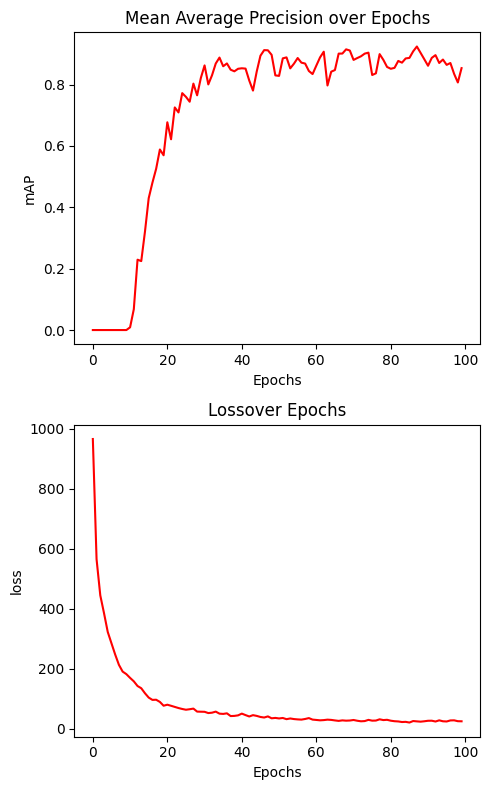

In [186]:
plt.figure(figsize=(5, 8))

# Plotting the loss
# plt.subplot(1).plot( loss, label='Loss', color='blue')

# Plotting the mAP
plt.subplot(2,1,1)
plt.plot( map, color='red')
plt.title('Mean Average Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('mAP')
 
plt.subplot(2,1,2)
plt.plot( loss, color='red')
plt.title('Lossover Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
# plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_34/809077920.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes=torch.tensor(boxes)


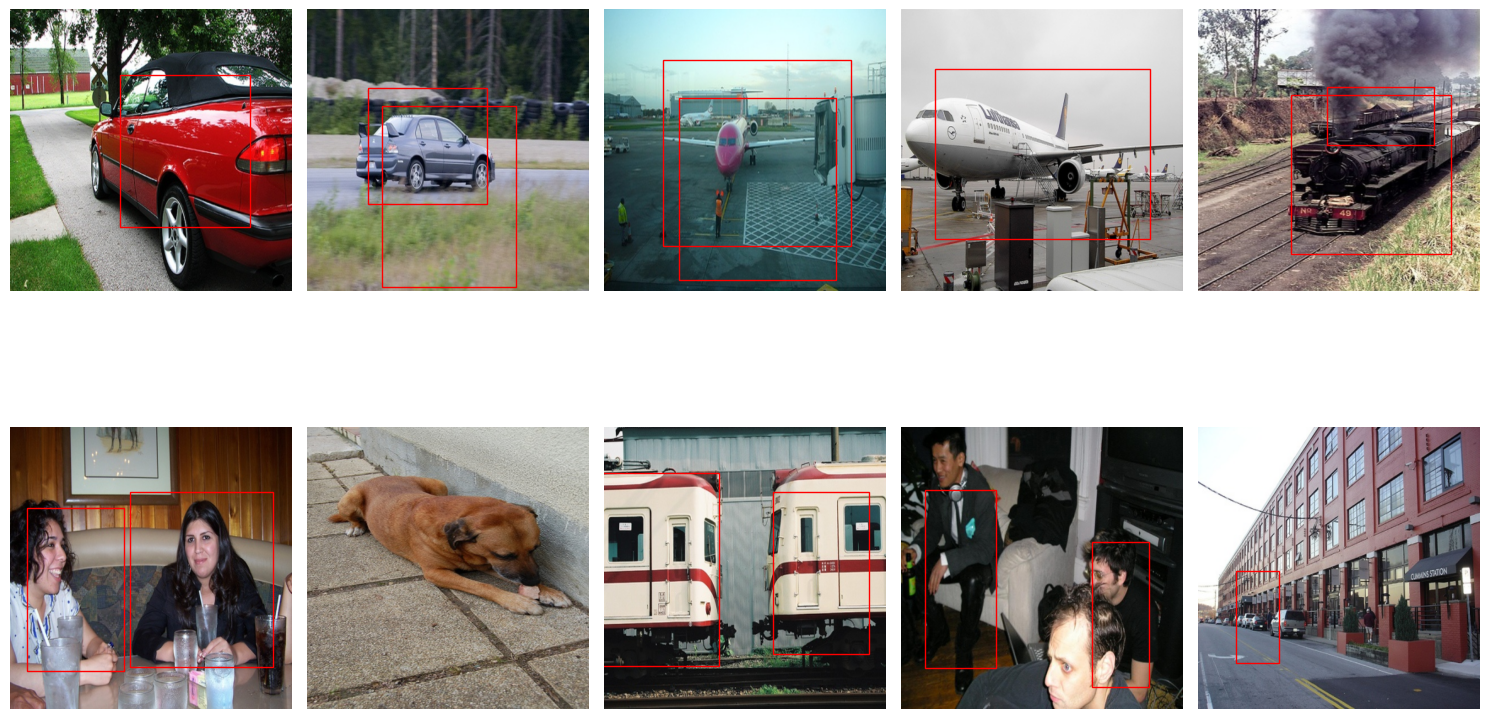

In [202]:
fig,axs= plt.subplots(2,5,figsize=(15,10))
axs=axs.ravel()
trainDataset=PacsalDataset("/kaggle/input/pascalvoc-yolo/100examples.csv","/kaggle/input/pascalvoc-yolo/images","/kaggle/input/pascalvoc-yolo/labels",transform=transformations)
for i in range(10):
    image,label=trainDataset[i]
    image=image.to(DEVICE)
    with torch.no_grad():
        out=model(image.unsqueeze(0))
    boxes=cell_to_boxes(out.unsqueeze(0))
    nms_box=NMS(boxes[0],0.5,0.5,box_format="midpoint")

    axs[i]=plot_images(image,nms_box,axs,i)

plt.tight_layout()
plt.show()
    
    